In [1]:
import sys
sys.path.insert(0,"/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.insert(0,"/scratch/group/csce435-f24/thicket")

import math
import matplotlib.pyplot as plt
import pandas as pd
import thicket as th
from copy import deepcopy
from glob import glob

# import matplotlib.pyplot as plt
# import pandas as pd
# import thicket as th

# from copy import deepcopy
# from glob import glob

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
# #1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
# tk = th.Thicket.from_caliperreader(glob("../Cali_Files/Radix/*/*.cali"))
tk = th.Thicket.from_caliperreader(glob("../Cali_Files/Radix/**/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 222/222 [00:07<00:00, 28.32it/s]


In [3]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

2.623 main
├─ 0.003 MPI_Comm_dup
├─ 0.000 MPI_Finalize
├─ 0.000 MPI_Finalized
├─ 0.000 MPI_Initialized
└─ 2.620 main
   ├─ 0.255 MPI_Barrier
   ├─ 0.000 MPI_Init
   ├─ 0.434 comm
   │  ├─ 0.426 comm_large
   │  │  ├─ 0.017 MPI_Isend
   │  │  └─ 0.384 MPI_Recv
   │  └─ 0.008 comm_small
   │     ├─ 0.001 MPI_Isend
   │     └─ 0.006 MPI_Recv
   ├─ 0.169 comp
   │  ├─ 0.164 comp_large
   │  └─ 0.005 comp_small
   ├─ 0.000 correctness_check
   └─ 0.023 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 2.62 indices: {'profile': 22368536})
█ 2.36 - 2.62
█ 1.84 - 2.36
█ 1.31 - 1.84
█ 0.79 - 1.31
█ 0.26 - 0.79
█ 0.00 - 0.26

name User code    ◀  Only in left graph    ▶  Only in right graph



In [4]:
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")
tk.metadata_column_to_perfdata("num_procs")

#tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size", "input_type"]).sort_index()
tk.dataframe = tk.dataframe.reset_index()
tk.dataframe = tk.dataframe[tk.dataframe['num_procs'] != 1024]

# tk.dataframe

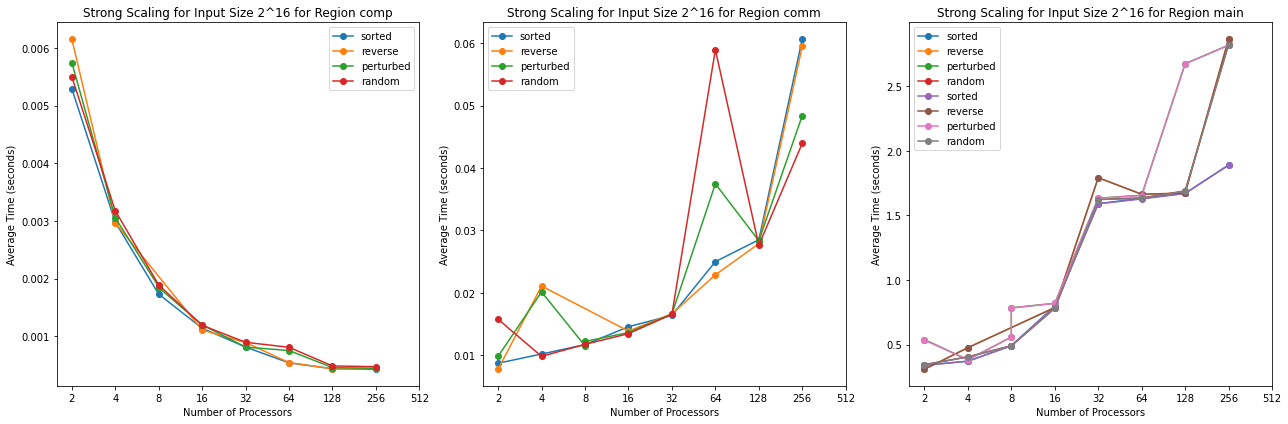

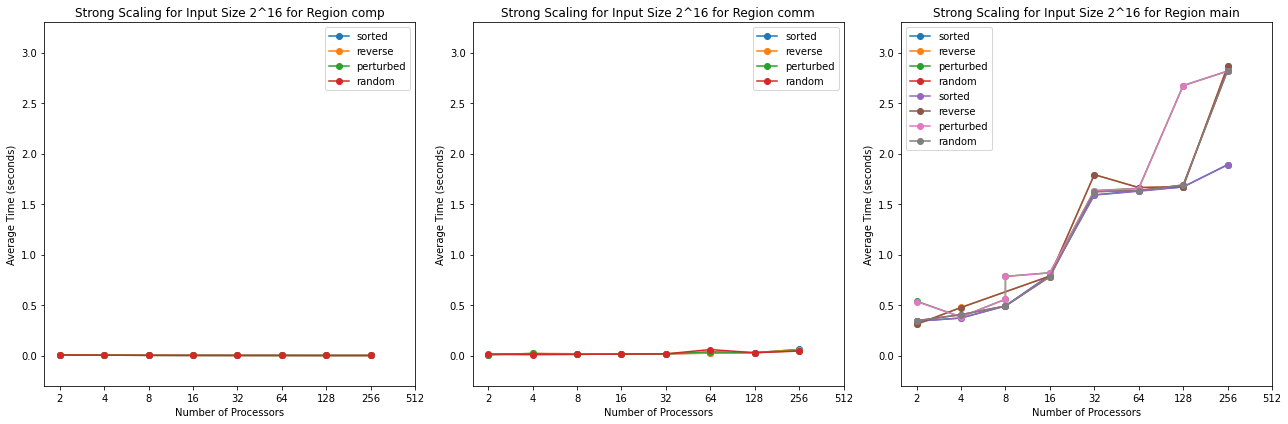

In [5]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# input_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
input_sizes = [65536]

# Custom formatter function to show integers instead of 2^1, 2^2, etc.
def log_formatter(x, pos):
    return f'{int(x):d}'

# Mapping for input types
input_type_mapping = {
    0: 'sorted',
    1: 'reverse',
    2: 'perturbed',
    3: 'random'
}

def plot_strong_scaling(tk, input_sizes):
    node_names = ['comp', 'comm', 'main']  # We will plot these regions
    fig, axes = plt.subplots(nrows=1, ncols=len(node_names), figsize=(18, 6))  # No sharey=True to give each its own y-axis
    
    for ax, node_name in zip(axes, node_names):  # Iterate through axes and node names
        for node in tk.graph.traverse():
            if node.frame['name'] == node_name:
                for input_size in input_sizes:
                    for input_type in [0, 1, 2, 3]:
                        data = tk.dataframe[(tk.dataframe["input_type"] == input_type) & 
                                            (tk.dataframe["input_size"] == input_size) & 
                                            (tk.dataframe['node'] == node)]
                        data = data.sort_values(by="num_procs")
                        label = input_type_mapping[input_type]  # Get the label from the mapping
                        ax.plot(data["num_procs"], data["Avg time/rank"], marker='o', label=label)

                    # Set title, labels, and legend for each subplot
                    ax.set_title(f'Strong Scaling for Input Size 2^{int(math.log2(input_size))} for Region {node_name}')
                    ax.set_xlabel('Number of Processors')
                    ax.set_ylabel('Average Time (seconds)')
                    ax.legend()

                    # Set x-axis to log scale (base 2)
                    ax.set_xscale('log', base=2)

                    # Set specific x-ticks
                    ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512]
                    ax.set_xticks(ticks)

                    # Use FuncFormatter to label ticks as plain integers
                    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))


    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()
    
def plot_strong_scaling_padding(tk, input_sizes):
    node_names = ['comp', 'comm', 'main']  # We will plot these regions
    fig, axes = plt.subplots(nrows=1, ncols=len(node_names), figsize=(18, 6))  # No sharey=True to give each its own y-axis
    
    for ax, node_name in zip(axes, node_names):  # Iterate through axes and node names
        for node in tk.graph.traverse():
            if node.frame['name'] == node_name:
                for input_size in input_sizes:
                    for input_type in [0, 1, 2, 3]:
                        data = tk.dataframe[(tk.dataframe["input_type"] == input_type) & 
                                            (tk.dataframe["input_size"] == input_size) & 
                                            (tk.dataframe['node'] == node)]
                        data = data.sort_values(by="num_procs")
                        label = input_type_mapping[input_type]  # Get the label from the mapping
                        ax.plot(data["num_procs"], data["Avg time/rank"], marker='o', label=label)

                    # Set title, labels, and legend for each subplot
                    ax.set_title(f'Strong Scaling for Input Size 2^{int(math.log2(input_size))} for Region {node_name}')
                    ax.set_xlabel('Number of Processors')
                    ax.set_ylabel('Average Time (seconds)')
                    ax.legend()

                    # Set x-axis to log scale (base 2)
                    ax.set_xscale('log', base=2)

                    # Set specific x-ticks
                    ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512]
                    ax.set_xticks(ticks)

                    # Use FuncFormatter to label ticks as plain integers
                    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    
                    padding = 0.1 * (3 - 0)
                    ax.set_ylim([0 - padding, 3 + padding])


    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()    

plot_strong_scaling(tk, input_sizes)
plot_strong_scaling_padding(tk, input_sizes)


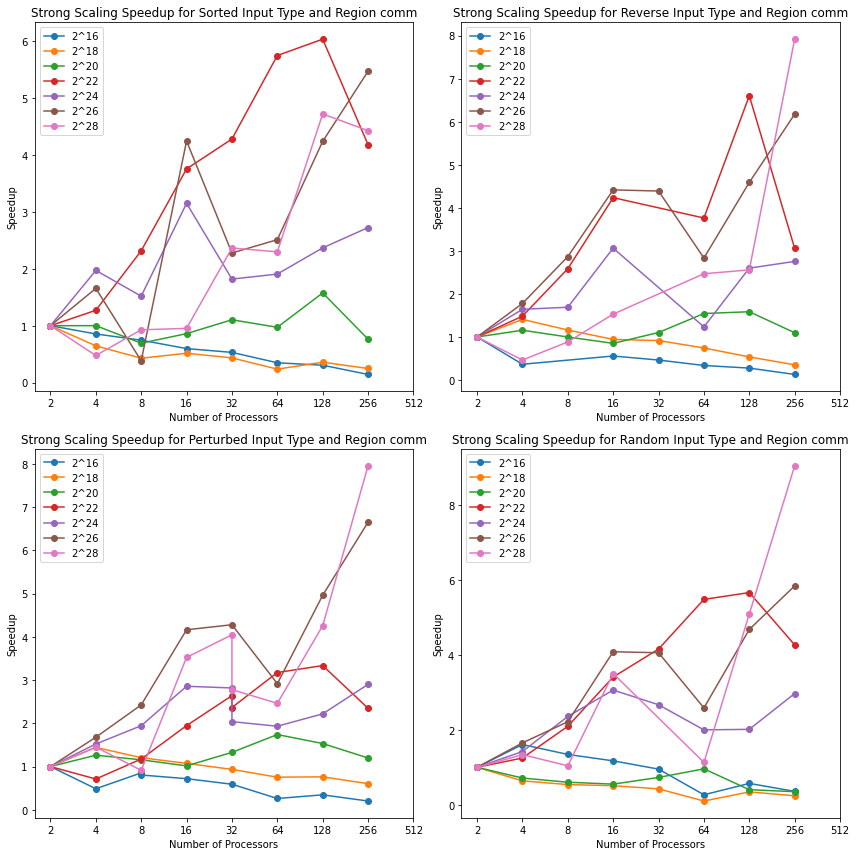

In [6]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# input_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
input_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]

# Custom formatter function to show integers instead of 2^1, 2^2, etc.
def log_formatter(x, pos):
    return f'{int(x):d}'

# Mapping from input_type integers to descriptive strings
input_type_map = {
    0: 'sorted',
    1: 'reverse',
    2: 'perturbed',
    3: 'random'
}

def plot_strong_scaling_speedup(tk, input_sizes):
    input_types = [0, 1, 2, 3]  # We will plot these input types
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))  # No sharey=True to give each its own y-axis
    axes = axes.flatten()

    for ax, input_type in zip(axes, input_types):  # Iterate through axes and input types
        for node in tk.graph.traverse():
            if node.frame['name'] in ['comm']:  # Filter by the desired node names
                for input_size in input_sizes:
                    data = tk.dataframe[(tk.dataframe["input_type"] == input_type) & 
                                        (tk.dataframe["input_size"] == input_size) & 
                                        (tk.dataframe['node'] == node)]
                    data = data.sort_values(by="num_procs")

                    # Get the average time for 2 processors to normalize the speedup
                    time_for_2_procs = data.loc[data["num_procs"] == 2, "Avg time/rank"].values[0]

                    # Compute speedup by dividing time for 2 processors by the current time
                    speedup = time_for_2_procs / data["Avg time/rank"]

                    ax.plot(data["num_procs"], speedup, marker='o', label=f'2^{int(math.log2(input_size))}')

        # Set title, labels, and legend for each subplot
        ax.set_title(f'Strong Scaling Speedup for {input_type_map[input_type].capitalize()} Input Type and Region comm')
        ax.set_xlabel('Number of Processors')
        ax.set_ylabel('Speedup')
        ax.legend()

        # Set x-axis to log scale (base 2)
        ax.set_xscale('log', base=2)

        # Set specific x-ticks
        ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512]
        ax.set_xticks(ticks)

        # Use FuncFormatter to label ticks as plain integers
        ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

plot_strong_scaling_speedup(tk, input_sizes)


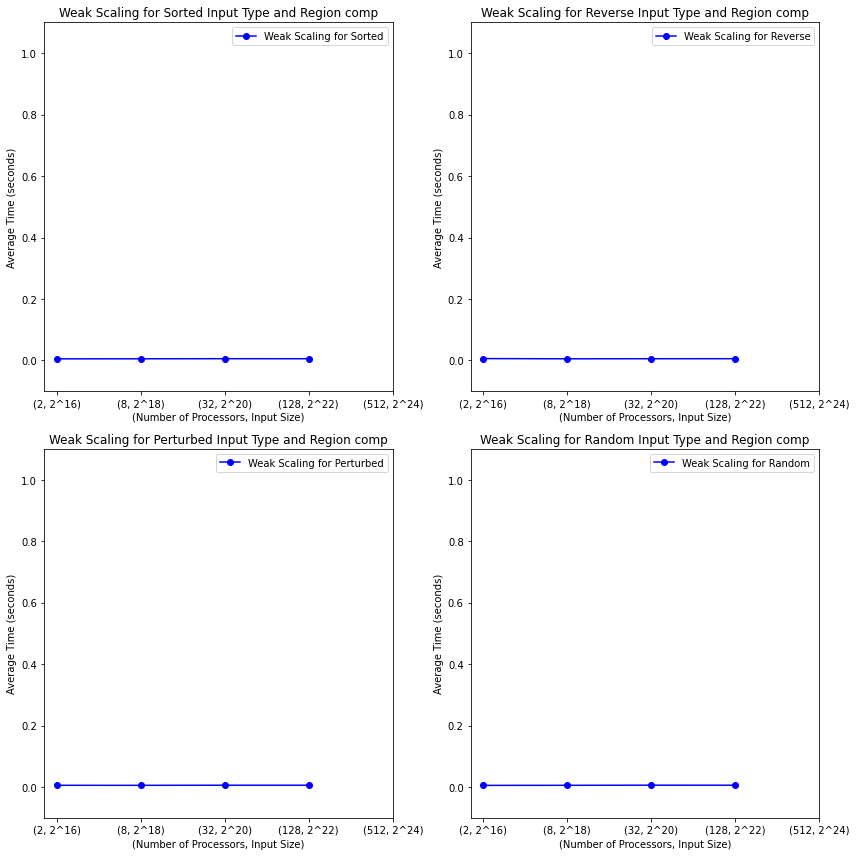

In [7]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

input_sizes = [65536, 262144, 1048576, 4194304, 16777216]
num_procs_list = [2, 8, 32, 128, 512]  # The processors corresponding to each input size

# Custom formatter to show (num_procs, 2^input_size_exponent) format
def log_formatter(x, pos):
    num_procs_exp_map = {
        2: 16,  # 2^16
        8: 18,  # 2^18
        32: 20, # 2^20
        128: 22, # 2^22
        512: 24  # 2^24
    }
    if x in num_procs_exp_map:
        return f'({int(x)}, 2^{num_procs_exp_map[int(x)]})'
    return ''

# Dictionary to map input types to their corresponding names
input_type_map = {
    0: 'Sorted',
    1: 'Reverse',
    2: 'Perturbed',
    3: 'Random'
}

def plot_weak_scaling(tk, input_sizes, num_procs_list):
    input_types = [0, 1, 2, 3]  # We will plot these input types
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))  # No sharey=True to give each its own y-axis
    axes = axes.flatten()

    for ax, input_type in zip(axes, input_types):  # Iterate through axes and input types
        for node in tk.graph.traverse():
            if node.frame['name'] in ['comp']:  # Filter by the desired node names
                # Create empty lists to store the points
                x_vals = []
                y_vals = []

                for num_procs, input_size in zip(num_procs_list, input_sizes):  # Iterate through specific points
                    data = tk.dataframe[(tk.dataframe["input_type"] == input_type) & 
                                        (tk.dataframe["input_size"] == input_size) & 
                                        (tk.dataframe['num_procs'] == num_procs) & 
                                        (tk.dataframe['node'] == node)]  # Filter for exact (num_procs, input_size)
                    data = data.sort_values(by="num_procs")

                    # Append the data points to the lists
                    if not data.empty:  # Ensure there is data to plot
                        x_vals.append(num_procs)
                        y_vals.append(data["Avg time/rank"].values[0])  # Get the average time for the point

                # Plot the line connecting the points
                ax.plot(x_vals, y_vals, marker='o', label=f'Weak Scaling for {input_type_map[input_type]}', linestyle='-', color='b')

        # Set title, labels, and legend for each subplot
        ax.set_title(f'Weak Scaling for {input_type_map[input_type]} Input Type and Region comp')
        ax.set_xlabel('(Number of Processors, Input Size)')
        ax.set_ylabel('Average Time (seconds)')
        ax.legend()

        # Set x-axis to log scale (base 2)
        ax.set_xscale('log', base=2)

        # Set specific x-ticks
        ticks = num_procs_list  # Set x-ticks to match the exact processor values
        ax.set_xticks(ticks)

        # Use FuncFormatter to label ticks in the desired format
        ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))
        padding = 0.1 * (1 - 0)
        ax.set_ylim([0 - padding, 1 + padding])

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

plot_weak_scaling(tk, input_sizes, num_procs_list)
